In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [ ]:
import os
import numpy as np
import pandas as pd
import glob
import math

In [ ]:
from utils import make_uID
det = pd.read_csv('input/detectors.csv')
det.head()
hits_pd = make_uID(det)
total_modules = hits_pd.shape[0]
print(total_modules)
max_nhits = 20

### load one event

In [7]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('input/train_1', event_prefix))

In [8]:
hits_with_uID = pd.merge(hits, hits_pd, on=['volume_id', 'layer_id', 'module_id'])
from utils import get_features
hits_final = get_features(hits_with_uID)
hits_final.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,uID,x2,y2,z2,r2,r,eta,phi,absZ
0,1,-64.409897,-7.163700,-1502.5,7,2,1,0,-0.042829,-0.004763,-23.184208,64.807045,1503.896973,-3.837108,-3.030827,1502.5
1,2,-55.336102,0.635342,-1502.5,7,2,1,0,-0.036804,0.000423,-27.150467,55.339748,1503.518799,-3.994889,3.130112,1502.5
2,3,-83.830498,-1.143010,-1502.5,7,2,1,0,-0.055707,-0.000760,-17.921406,83.838287,1504.837158,-3.579932,-3.127959,1502.5
3,4,-96.109100,-8.241030,-1502.5,7,2,1,0,-0.063835,-0.005474,-15.576118,96.461777,1505.593262,-3.439919,-3.056055,1502.5
4,5,-62.673599,-9.371200,-1502.5,7,2,1,0,-0.041676,-0.006232,-23.709833,63.370335,1503.835815,-3.859459,-2.993168,1502.5


In [9]:
shuffled = shuffle_hits(truth, 0.05) # 5% probability to reassign a hit
score = score_event(truth, shuffled)

In [10]:
print(score)

0.949480159757


In [8]:
filtered_truth = truth[ (truth['weight'] > 5e-7 ) & (truth['particle_id'] != 0) ]
training = hits_final.merge(filtered_truth, on='hit_id')[['uID', 'particle_id']]

In [9]:
truth_particles = pd.Series(np.unique(training['particle_id']))
print("total particles:", truth_particles.shape[0])

total particles: 9292


In [25]:

print(len(train))

1770


In [35]:
def load_training():
    train = np.unique([p.split('-')[0] for p in sorted(glob.glob('input/train_1/**'))])
    training_df = []
    for ds_name in train:
        hits, truth = load_event(ds_name, parts=['hits', 'truth'])
        hits_with_uID = pd.merge(hits, hits_pd, on=['volume_id', 'layer_id', 'module_id'])
        filtered_truth = truth[ (truth['weight'] > 5e-7 ) & (truth['particle_id'] != 0) ]
        training = hits_with_uID.merge(filtered_truth, on='hit_id')[['uID', 'particle_id']]
        unique_truth = pd.Series(np.unique(training['particle_id']))
        
        training_df.append( (training, unique_truth) )
    return training_df

In [36]:
all_train_1 = load_training()

# summary of training events from *train_1*

In [39]:
print("Total events:", len(all_train_1))
print("Total truth particles:", sum([y.shape[0] for x,y in all_train_1]))

Total events: 1770
Total truth particles: 14496495


In [42]:
import random

# random item from a list
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrack(df_train, df_truth):
    pID = df_truth.sample(1).values
    hit_series = df_train[df_train['particle_id'] == pID[0]]['uID'].values
    input_tensor = inputHits(hit_series)
    target_tensor = targetHits(hit_series)
    return input_tensor, target_tensor

def random_from_training():
    df_train, df_truth = random_choice(all_train_1)
    return randomTrack(df_train, df_truth)

def tunable_parameters(model):
    model_parameters = filter(lambda p:p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    # return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params

In [41]:
print(random_from_training())

(tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]), tensor([  1360,   2150,   3344,   3452,   5859,  10969,  11139,  11307,
         11310,  11477,  11648,  18728]))


### Try the RNN model

In [10]:
class HitPredictor(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=20, output_dim=20,
                n_lstm_layers=1):
        super(HitPredictor, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.batch_size = 1
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_lstm_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self):
        return (torch.zeros(self.lstm.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.lstm.num_layers, self.batch_size, self.hidden_dim))
        
    def forward(self, x):
        output, self.hidden = self.lstm(x, self.hidden)
        output = self.fc(output.view(len(x), -1))
        output = self.dropout(output)
        tag_scores = self.softmax(output)
        return tag_scores

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [12]:
class HitPredictorSteve(nn.Module):
    """RNN which predicts sequence of next-hits from input sequence"""

    def __init__(self, input_dim=3, hidden_dim=5, output_dim=2,
                 n_lstm_layers=1):
        super(HitPredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_lstm_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        input_size = x.size()
        # Initialize the lstm hidden state
        torch_zeros = torchutils.torch_zeros
        func_args = (self.lstm.num_layers, input_size[0], self.lstm.hidden_size)
        h = (torch_zeros(*func_args), torch_zeros(*func_args))
        x, h = self.lstm(x, h)
        # Flatten layer axis into batch axis so FC applies
        # independently across layers.
        x = (self.fc(x.contiguous().view(-1, x.size(-1)))
             .view(input_size[0], input_size[1], -1))
        return x

In [13]:
def inputHits(series):
    tensor = torch.zeros(len(series), 1, total_modules+1)
    for idx, h in enumerate(series):
        tensor[idx][0][h] = 1

    return tensor

In [14]:
def targetHits(series):
    module_idx = series[1:].tolist()
    module_idx.append(total_modules)
    return torch.LongTensor(module_idx)

In [15]:
def randomTrack():
    pID = truth_particles.sample(1).values
    hit_series = training[training['particle_id'] == pID[0]]['uID'].values
    input_tensor = inputHits(hit_series)
    target_tensor = targetHits(hit_series)
    return input_tensor, target_tensor

In [16]:
def getInputTarget(hit_series):
    input_tensor = inputHits(hit_series)
    target_tensor = targetHits(hit_series)
    return input_tensor, target_tensor

In [18]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [19]:
def check_result(input_, tags_, target_):
    with torch.no_grad():
        print("inputs:", torch.reshape(torch.argmax(input_, dim=2), (-1,)))
        print("predictions:", torch.argmax(tags_, dim=1))
#         print("target:", target_)

In [43]:
def tunable_parameters(model):
    model_parameters = filter(lambda p:p.requires_grad, model.parameters())
#     for p in model_parameters:
#         print(p.size())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [51]:
rnn = HitPredictor(input_dim=total_modules+1, hidden_dim=20, 
                   output_dim=total_modules+1,
                   n_lstm_layers=1)
print("total parameters:", tunable_parameters(rnn))

total parameters: 1893389


In [ ]:
optimizer.param_groups

In [50]:
rnn = HitPredictor(input_dim=total_modules+1, hidden_dim=25, 
                   output_dim=total_modules+1,
                   n_lstm_layers=1)
print("total parameters:", tunable_parameters(rnn))

total parameters: 2362554


In [34]:
rnn = HitPredictor(input_dim=total_modules+1, hidden_dim=128, 
                   output_dim=total_modules+1,
                   n_lstm_layers=2)
print("total parameters:", tunable_parameters(rnn))

total parameters: 12203945


In [36]:
rnn = HitPredictor(input_dim=3, hidden_dim=64, 
                   output_dim=3,
                   n_lstm_layers=1)
print("total parameters:", tunable_parameters(rnn))

total parameters: 17859


### Train RNN with all tracks in this event
This seems not work!
After some time training, it predicts only the last hit.

Now, can I have a RNN what at least predict one track correctly?

In [ ]:
criterion = nn.NLLLoss()
rnn = HitPredictor(input_dim=total_modules+1, hidden_dim=20, 
                   output_dim=total_modules+1,
                   n_lstm_layers=1)

total_tunable = tunable_parameters(rnn)
print('total parameters in RNN:', total_tunable)

In [ ]:
n_iters = total_tunable*2
print_every = int(n_iters/50)
plot_every = int(n_iters/1000)
all_losses = []
total_loss = 0
start = time.time()

optimizer = optim.SGD(rnn.parameters(), lr=0.01, momentum=0.9)

for iter_ in range(n_iters):

#     input_, target_ = randomTrack()
    input_, target_ = random_from_training()
    
    # training
    rnn.zero_grad()
    rnn.hidden = rnn.init_hidden()
    
    loss = 0
    
    output = rnn(input_)    
    loss = criterion(output, target_)

#     for i in range(input_.size(0) - 1):
#         output = rnn(input_[i].view(1, 1, -1))
#         loss += criterion(output, torch.tensor([target_[i]]))

    loss.backward()
    optimizer.step()
    
    normed_loss = loss.item()/input_.size(0)
    total_loss += normed_loss
    if iter_ % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter_, iter_ / n_iters * 100, normed_loss))
        check_result(input_, output, target_)
        
    if iter_ % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

print("I am done")

total parameters in RNN: 1893389
0m 0s (0 0%) 0.9008
inputs: tensor([  84,  192,  194,  300,  302,  408,  410,  516,  518,  624,
         626])
predictions: tensor([ 16113,  13652,   3988,  13652,  13652,  13652,   3988,   3988,
         17489,  13652,  13652])
24m 59s (37867 1%) 0.8094
inputs: tensor([  1685,   2542,   5381,   5382,   6364,   7736,   9586,   9587,
         13374,  13375,  16142,  16143])
predictions: tensor([   867,   3448,  18728,  18728,  18728,  18728,  18728,  18728,
           740,  18728,  18728,  18728])
50m 32s (75734 3%) 0.8722
inputs: tensor([   845,   1126,   1561,   2200,   4771,   4772,   4944,   5206,
         11984,  12083])
predictions: tensor([   883,   3415,  18728,  18728,  18728,    448,  18728,    648,
         18728,  18728])
77m 16s (113601 5%) 0.7084
inputs: tensor([   864,   1197,   1781,   2685,   5455,   6467,   7801,   7879,
          9672,  13596,  16425])
predictions: tensor([   867,   1215,  18728,  18728,  18728,  18728,  18728,  18728,

In [55]:
torch.save(rnn.state_dict(), "trained_1event_rnn_model_01")

[tensor([ 18728,  11795,   3862]), tensor([ 18728,  11795,   3862]), tensor([ 18728,   3862,  16650]), tensor([ 11795,   3862,   4030]), tensor([ 18728,  11795,   3862]), tensor([ 18728,  11795,   3862]), tensor([ 18728,  11795,   3862]), tensor([ 18728,  11795,   3862]), tensor([ 18728,  11795,   3862]), tensor([ 11795,   3862,   4030]), tensor([ 18728,  11795,   3862]), tensor([ 18728,  11795,   3862]), tensor([ 18728,  11795,   3862]), tensor([ 18728,  11795,   3862]), tensor([ 11795,   3862,   4030]), tensor([ 18728,  11795,   3862]), tensor([ 18728,  11795,   3862]), tensor([ 18728,  11795,   4030]), tensor([ 18728,  11795,   3862]), tensor([ 18728,  11795,   3862])]


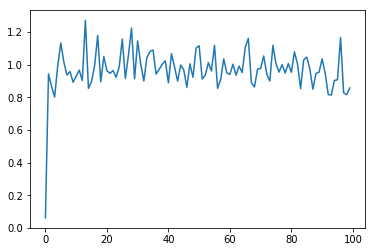

In [25]:
print(check_trainingPredictor(322))
plt.plot(all_losses)

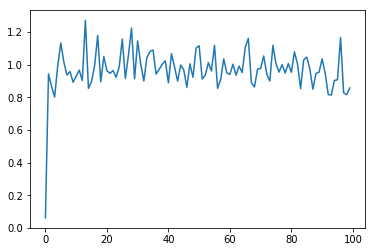

In [21]:
def check_trainingPredictor(start_hit):
    with torch.no_grad():
        input_tensor = inputHits([start_hit])
        rnn.hidden = rnn.init_hidden()
        out_hits = []
        pre_can = -1
        for i in range(max_nhits):
            output = rnn(input_tensor)
            topv, topi = output.topk(3)
            cand = topi[0][1]
#             if cand <= pre_can:
#                 break
#             else:
#                 pre_can = cand
            if cand == total_modules:
                print("Hit the last hits")
                break
            else:
                out_hits.append(topi[0])
            input_tensor = inputHits([cand])
        return out_hits

### Training with RNN
example is taken from: [link](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html).

In [ ]:
n_iters = truth_particles.shape[0]

n_iters = 1000
n_iters = truth_particles.shape[0] if n_iters > truth_particles.shape[0] else n_iters
print_every = n_iters/10
# print_every = 1
plot_every = 20
all_losses = []
total_loss = 0
start = time.time()


criterion = nn.NLLLoss()
rnn = RNN(total_modules+1, 512, total_modules+1)
optimizer = optim.SGD(rnn.parameters(), lr=0.01)

for iter_ in range(n_iters):
    pID = truth_particles.values[iter_]

    # prepare the inputs
    input_, target_ = getInputTarget(training[training['particle_id'] == pID]['uID'].values)
    
    # training
    rnn.zero_grad()
    hidden = rnn.initHidden()
   
    loss = 0
    for i in range(input_.size(0)):
        tag_scores, hidden = rnn(input_[i], hidden)
        loss += criterion(tag_scores, torch.tensor([target_[i]]))

#     tag_scores, hidden = rnn(input_, hidden)
#     loss = criterion(tag_scores, target_)
        
    loss.backward()
    optimizer.step()
    
    norm_loss = loss/input_.size(0)
    total_loss += norm_loss
    if iter_ % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter_, iter_ / n_iters * 100, norm_loss))
#         check_result(input_, tag_scores, target_)
        
    if iter_ % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

print("I am done")

1m 3s (0 0%) 9.8356


In [22]:

def check_training(start_hit):
    with torch.no_grad():
        input_tensor = inputHits([start_hit])
        print(input_tensor.size())
        print(input_tensor[0][0][start_hit])
        rnn.hidden = rnn.init_hidden()
        out_hits = []
        for i in range(max_nhits):
            output = rnn(input_tensor)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == total_modules:
                print("Hit the last hits")
                break
            else:
                out_hits.append(topi)
            input_tensor = inputHits([topi])
        return out_hits

In [25]:
def check_trainingRNN(start_hit):
    with torch.no_grad():
        input_tensor = inputHits([start_hit])
        hidden = rnn.initHidden()
        out_hits = []
        topi = start_hit
        for i in range(max_nhits):
#             print(input_tensor.size())
#             print(input_tensor[0][0][topi])
            print(topi)
            output, hidden = rnn(input_tensor[0], hidden)
            # print(output)
            # print(output.size())
            topv, topi = output.topk(3)
#             topi = topi[0][1]
            if topi[0][0] == total_modules:
                print("Hit the last hits")
                break
            else:
                out_hits.append(topi[0])
            topi = topi[0][0]
            input_tensor = inputHits([topi])
        return out_hits

In [72]:
check_trainingRNN(1150)

1150
tensor(1150)
tensor(1150)
tensor(1150)
tensor(1150)
tensor(1150)
tensor(1150)
tensor(10643)
tensor(1150)
tensor(1150)
tensor(1150)
tensor(1150)
tensor(1150)
tensor(1150)
tensor(1150)
tensor(10643)
tensor(2336)
tensor(3348)
tensor(12162)
tensor(12162)


[tensor([  1150,  10643,   2336]),
 tensor([  1150,  10643,   2336]),
 tensor([  1150,  10643,   2336]),
 tensor([  1150,  10643,   2336]),
 tensor([  1150,  10643,   2336]),
 tensor([  1150,  10643,   2336]),
 tensor([ 10643,   2336,  12162]),
 tensor([  1150,   2336,  18164]),
 tensor([  1150,  10643,  12162]),
 tensor([  1150,  10643,   2336]),
 tensor([  1150,  10643,   2336]),
 tensor([  1150,  10643,   2336]),
 tensor([  1150,  10643,   2336]),
 tensor([  1150,  10643,   2336]),
 tensor([ 10643,   2336,  12162]),
 tensor([  2336,  18164,  12162]),
 tensor([  3348,  12162,   2336]),
 tensor([ 12162,   2336,   3453]),
 tensor([ 12162,   7141,   2336]),
 tensor([ 12162,   2608,   2336])]

In [38]:
torch.save(rnn.state_dict(), "trained_1event_rnn_model")

In [20]:
input_, target = randomTrack()
rnn = HitPredictor(input_dim=total_modules+1, hidden_dim=128, output_dim=total_modules+1)

#target.unsqueeze_(-1)
rnn.hidden = rnn.init_hidden()

rnn.zero_grad()
loss = 0
criterion = nn.NLLLoss()

for i in range(input_.size(0) - 1):
    output = rnn(input_[0].view(1, 1, -1))
    loss += criterion(output, torch.tensor([target[i]]))
    

# print("input size:", input_.size())
# print('target size:', target.size())
# output = rnn(input_)
# print("output size:", output.size())
# print(target)
# loss = criterion(output, target)
print(loss)

tensor(127.8480)


In [ ]:
input_, target = randomTrack()

In [38]:

rnn = RNN(total_modules+1, 3, total_modules+1)

#target.unsqueeze_(-1)
hidden = rnn.initHidden()

rnn.zero_grad()
loss = 0
criterion = nn.NLLLoss()

print("input size:", input_.size())
print('target size:', target.size())
output, hidden = rnn(input_[0], hidden)
print("output size:", output.size())
print(target)
print(target[0])
loss = criterion(output, torch.tensor([target[0]]))
print(loss)

SyntaxError: invalid syntax (<ipython-input-38-24a2ed7d7105>, line 18)

In [37]:
print(output.size(0), torch.tensor([target[0]]).size(0))
loss = criterion(output, torch.tensor([target[0]]))

1 1


In [57]:
rnn2 = nn.LSTM(6, 20)
input = torch.randn(1)
print(input.size())
print(input.type())
print(input.dtype)
h0 = torch.randn(2, 1, 20)
c0 = torch.randn(2, 1, 20)
output, hn = rnn2(input, (h0, c0))
print(output)
print(output.size())
print(hn)
print(hn[0].size())

torch.Size([1])
torch.FloatTensor
torch.float32


RuntimeError: dimension out of range (expected to be in range of [-1, 0], but got 1)

In [163]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.tensor([1, 0, 4])
print(target.size())
print(m(input).size())
output = loss(m(input), target)

In [61]:
embedding = nn.Embedding(10, 3)
input = torch.LongTensor([1,2,4,5])
print(input)
embeds = embedding(input)

tensor([ 1,  2,  4,  5])


In [62]:
print(embeds.size())
print(input.size())
print(len(input))

torch.Size([4, 3])
torch.Size([4])
4


In [63]:
print(embeds)
new_embeds = embeds.view(len(input), 1, -1)
print(new_embeds)
print(new_embeds.size())

tensor([[-0.5956, -0.3846,  0.6718],
        [ 0.4788,  0.3929,  0.4087],
        [ 0.3090,  0.4232,  1.3487],
        [ 2.1231, -0.9157, -1.3121]])
tensor([[[-0.5956, -0.3846,  0.6718]],

        [[ 0.4788,  0.3929,  0.4087]],

        [[ 0.3090,  0.4232,  1.3487]],

        [[ 2.1231, -0.9157, -1.3121]]])
torch.Size([4, 1, 3])


In [26]:
rnn.parameters

<bound method Module.parameters of HitPredictor(
  (lstm): LSTM(18729, 128)
  (fc): Linear(in_features=128, out_features=18729, bias=True)
  (dropout): Dropout(p=0.1)
  (softmax): LogSoftmax()
)>

In [2]:
import pickle
a_list = [1, 3,4 ,45]
with open('outfile', 'wb') as fp:
    pickle.dump(a_list, fp)

In [3]:
with open('outfile', 'rb') as fp:
    my_list = pickle.load(fp)
    print(my_list)

[1, 3, 4, 45]


total parameters: 12071849
